<a href="https://colab.research.google.com/github/Nilanjan-Chatterjee/Aahar/blob/main/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#connecting the drive to colab
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


# **Initial**

In [2]:
!git clone https://github.com/Hexmagic/pytorch_yolov1
%cd /content/pytorch_yolov1

Cloning into 'pytorch_yolov1'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 367 (delta 18), reused 17 (delta 7), pack-reused 330
Receiving objects: 100% (367/367), 1.01 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (208/208), done.
/content/pytorch_yolov1


In [3]:
#import all the libraries
import os
import torch
import glob
from torch.utils.data import Dataset
import time
import copy
import numpy as np
import math
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import argparse
import logging
import sys
import cv2
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from collections import OrderedDict
import random

In [4]:
import math
from argparse import ArgumentParser
from collections import defaultdict

import numpy as np
import torch
from torch.autograd import Variable
from tqdm import tqdm

from data.dataloader import make_train_dataloader, make_valid_dataloader
from model.loss import yoloLoss
from model.yolo import build_yolo
from utils.lr_scheduler import make_lr_scheduler, make_optimizer
import time

In [5]:
#Creating dataset
class ListDataset(Dataset):
    def __init__(self, img_files,label_files, img_size=416):
        
        #super(DataLoaderSegmentation, self).__init__()
        #image_class=os.listdir(img_path)
        #self.img_files=[]
        #for cls in image_class:
         #   self.img_files += glob.glob(img_path+cls+'/'+'*.bmp')
       
        #self.label_files = []
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long
        self.img_files=img_files
        self.label_files=label_files
        
        #for img_path1 in self.img_files:
          
          #self.label_files.append(label_path+cls+'neucleus'+img_path1[-7:-4]+'.txt')
        self.img_shape = (img_size, img_size)
        self.max_objects = 98
        


    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):

        #---------
        #  Image
        #---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        dim_diff = np.abs(h - w)
        # Upper (left) and lower (right) padding
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding
        pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
        # Add padding
        pad_img = np.pad(img, pad, 'constant', constant_values=128)

        padded_h, padded_w, _ = pad_img.shape

        # Resize
        pad_img = cv2.resize(pad_img, self.img_shape)
        # Channels-first
        input_img = pad_img[:, :, ::-1].transpose((2, 0, 1)).copy()
        # As pytorch tensor
        input_img = torch.from_numpy(input_img).float().div(255.0)

        #---------
        #  Label
        #---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()

        labels = None
        if os.path.exists(label_path):
            
            labels = np.loadtxt(label_path).reshape(-1, 5)
           
            # Extract coordinates for unpadded + unscaled image
            x1 = w * (labels[:, 1] - labels[:, 3]/2)
            y1 = h * (labels[:, 2] - labels[:, 4]/2)
            x2 = w * (labels[:, 1] + labels[:, 3]/2)
            y2 = h * (labels[:, 2] + labels[:, 4]/2)
            # Adjust for added padding
            x1 += pad[1][0]
            y1 += pad[0][0]
            x2 += pad[1][0]
            y2 += pad[0][0]
            # Calculate ratios from coordinates
            labels[:, 1] = ((x1 + x2) / 2) / padded_w
            labels[:, 2] = ((y1 + y2) / 2) / padded_h
            labels[:, 3] *= w / padded_w
            labels[:, 4] *= h / padded_h
        # Fill matrix
        filled_labels = np.zeros((self.max_objects, 5))
        if labels is not None:
            filled_labels[range(len(labels))[:self.max_objects]] = labels[:self.max_objects]
        filled_labels = torch.from_numpy(filled_labels)
        
        sample = {'input_img': input_img, 'orig_img': pad_img, 'label': filled_labels, 'path': img_path}

        return sample

In [28]:
#creating dataloader
batch_size = 1
inp_dim = 448
input_path='/content/gdrive/MyDrive/Sipakmed/'
output_path='/content/gdrive/MyDrive/Sipakmed_results3/'
image_class=os.listdir(input_path)
img_files=[]
for cls in image_class:
  temp=glob.glob(input_path+cls+'/'+'*.bmp') 
  for i in range(len(temp)):
    img_files.append([temp[i],cls])
random.shuffle(img_files)       
label_files = []
inputs_dtype = torch.float32
targets_dtype = torch.long
for img_path1 in img_files:
    label_files.append(output_path+img_path1[1]+'/neucleus'+img_path1[0][-7:-4]+'.txt')
print(len(label_files))
for i in range(len(img_files)):
  img_files[i]=img_files[i][0]

train_img=img_files[:576]      #576 data
val_img=img_files[576:780]     #204 data
test_img=img_files[780:]       #192 data

train_label=label_files[:576]
val_label=label_files[576:780]
test_label=label_files[780:]

dataloaders = {'train': torch.utils.data.DataLoader(ListDataset(train_img,train_label, img_size=inp_dim), batch_size=batch_size, shuffle=True,num_workers=1),
               'val': torch.utils.data.DataLoader(ListDataset(val_img,val_label, img_size=inp_dim), batch_size=batch_size, shuffle=True,num_workers=1)}
dataloaders_test=torch.utils.data.DataLoader(ListDataset(test_img,test_label, img_size=inp_dim), batch_size=batch_size, shuffle=True,num_workers=1)
#print(dataloaders['train'])
print(len(dataloaders['val']))
for i_batch, sample_batched in enumerate(dataloaders_test):
    input_images_batch, Orig_images_batch, label_batch, path_batch = sample_batched['input_img'], sample_batched['orig_img'], sample_batched['label'], sample_batched['path']
    print('nare',i_batch, input_images_batch.shape, Orig_images_batch.shape, label_batch.shape)
    print(input_images_batch)
    print(label_batch)
    if i_batch == 0:
        break

966
204
nare 0 torch.Size([1, 3, 448, 448]) torch.Size([1, 448, 448, 3]) torch.Size([1, 98, 5])
tensor([[[[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]],

         [[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          ...,
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020]],

         [[0.5020, 0.5020, 0.5020,  ..., 0.5020, 0.5020, 0.5020],
          [0

# **Main**

In [7]:

from torch import nn
from model.vgg import build_vgg
import torch
import math
class YoLo(nn.Module):
    def __init__(self, features, num_classes=2):
        super(YoLo, self).__init__()
        self.features = features
        self.classify = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                      nn.ELU(inplace=True),
                                      nn.Dropout(),
                                      nn.Linear(4096, 588))

    def init_param(self):
        for m in self.classify():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        x = torch.sigmoid(x)
        return x.view(-1, 7, 7, 12)
def build_yolo():
    vgg = build_vgg()
    net = YoLo(vgg.features)
    return net

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import *


class yoloLoss(Module):
    def __init__(self, num_class=2):
        super(yoloLoss, self).__init__()
        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.S = 7
        self.B = 2
        self.C = num_class
        self.step = 1.0 / 7

    def compute_iou(self, box1, box2, index):
        box1 = torch.clone(box1)
        box2 = torch.clone(box2)
        box1 = self.conver_box(box1, index)
        box2 = self.conver_box(box2, index)
        x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
        # 获取相交
        inter_w = (w1 + w2) - (torch.max(x1 + w1, x2 + w2) - torch.min(x1, x2))
        inter_h = (h1 + h2) - (torch.max(y1 + h1, y2 + h2) - torch.min(y1, y2))
        inter_h = torch.clamp(inter_h, 0)
        inter_w = torch.clamp(inter_w, 0)
        # 往下进行应该inter 和 union都是正值
        inter = inter_w * inter_h
        union = w1 * h1 + w2 * h2 - inter
        return inter / union

    def conver_box(self, box, index):
        i, j = index
        box[:, 0], box[:, 1] = [(box[:, 0] + i) * self.step - box[:, 2] / 2,
                                (box[:, 1] + j) * self.step - box[:, 3] / 2]
        box = torch.clamp(box, 0)
        return box

    def forward(self, pred, target):
        batch_size = pred.size(0)
        target_boxes = target[:, :, :, :10].contiguous().reshape(
            (-1, 7, 7, 2, 5))
        pred_boxes = pred[:, :, :, :10].contiguous().reshape((-1, 7, 7, 2, 5))
        target_cls = target[:, :, :, 10:]
        pred_cls = pred[:, :, :, 10:]
        obj_mask = (target_boxes[..., 4] > 0).byte()
        sig_mask = obj_mask[..., 1].bool()
        index = torch.where(sig_mask == True)

        for img_i, y, x in zip(*index):
            img_i, y, x = img_i.item(), y.item(), x.item()
            pbox = pred_boxes[img_i, y, x]
            target_box = target_boxes[img_i, y, x]
            ious = self.compute_iou(pbox[:, :4], target_box[:, :4], [x, y])
            iou, max_i = ious.max(0)
            pred_boxes[img_i, y, x, max_i, 4] = iou.item()
            pred_boxes[img_i, y, x, 1 - max_i, 4] = 0
            obj_mask[img_i, y, x, 1 - max_i] = 0
        obj_mask = obj_mask.bool()
        noobj_mask = ~obj_mask

        noobj_loss = F.mse_loss(pred_boxes[noobj_mask][:, 4],
                                target_boxes[noobj_mask][:, 4],
                                reduction="sum")
        obj_loss = F.mse_loss(pred_boxes[obj_mask][:, 4],
                              target_boxes[obj_mask][:, 4],
                              reduction="sum")
        xy_loss = F.mse_loss(pred_boxes[obj_mask][:, :2],
                             target_boxes[obj_mask][:, :2],
                             reduction="sum")
        wh_loss = F.mse_loss(torch.sqrt(target_boxes[obj_mask][:, 2:4]),
                             torch.sqrt(pred_boxes[obj_mask][:, 2:4]),
                             reduction="sum")
        """class_loss = F.mse_loss(pred_cls[sig_mask],
                                target_cls[sig_mask],
                                reduction="sum")
"""
        loss = dict(conf_loss=(obj_loss + self.lambda_noobj * noobj_loss) /
                    batch_size,
                    reg_loss=(self.lambda_coord * xy_loss +
                              self.lambda_coord * wh_loss) / batch_size,
                    cls_loss=0)#class_loss / batch_size)
        return loss

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [11]:
model = model.cuda()
criterion = yoloLoss().cuda()
optim = make_optimizer(model)
#model.train()
#model.classify[3]=nn.Linear(4096,588)
model

YoLo(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (

In [ ]:
import math
from argparse import ArgumentParser
from collections import defaultdict

import numpy as np
import torch
from torch.autograd import Variable
from tqdm import tqdm

from data.dataloader import make_train_dataloader, make_valid_dataloader
from model.loss import yoloLoss
from model.yolo import build_yolo
from utils.lr_scheduler import make_lr_scheduler, make_optimizer
import time
model=model.cuda()
for i_, sample_batched in enumerate(dataloaders["train"]):
    img, Orig_images_batch, label_batch, path_batch = sample_batched['input_img'], sample_batched['orig_img'], sample_batched['label'], sample_batched['path']
    #print(img.shape)
    img=img.cuda()
    label_batch=label_batch.cuda()
    output=model(img)
    #print(output.shape)
    optim.zero_grad()
    #print(label_batch.shape)
    label_batch=label_batch.reshape(1,7,7,2,5)
    #print(label_batch.shape)
    loss_dict = criterion(output, label_batch.float())
    #record_loss(loss_dict, recoder)
    loss = sum(x for x in loss_dict.values())
    loss.backward()
    optim.step()
    print(i_,"      ",loss)
   

0        tensor(0.2325, device='cuda:0', grad_fn=<AddBackward0>)
1        tensor(0.2662, device='cuda:0', grad_fn=<AddBackward0>)
2        tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>)
3        tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)
4        tensor(0.2954, device='cuda:0', grad_fn=<AddBackward0>)
5        tensor(2.9404, device='cuda:0', grad_fn=<AddBackward0>)
6        tensor(2.6074, device='cuda:0', grad_fn=<AddBackward0>)
7        tensor(1.3662, device='cuda:0', grad_fn=<AddBackward0>)
8        tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)
9        tensor(1.1122, device='cuda:0', grad_fn=<AddBackward0>)
10        tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)
11        tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)
12        tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)
13        tensor(1.1309, device='cuda:0', grad_fn=<AddBackward0>)
14        tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)
15        tensor(0.0

nothing

Streaming output truncated to the last 5000 lines.
 [[0.5019608  0.78431374 0.5882353 ]
  [0.5019608  0.8235294  0.81960785]
  [0.8509804  0.5019608  0.9764706 ]
  ...
  [0.87058824 0.8235294  0.8784314 ]
  [0.5019608  0.84313726 0.6       ]
  [0.8235294  0.96862745 0.9607843 ]]

 [[1.         0.5019608  0.85490197]
  [0.52156866 0.79607844 0.5019608 ]
  [0.8352941  0.8117647  0.5019608 ]
  ...
  [0.9529412  0.5019608  0.85490197]
  [0.87058824 0.5019608  0.80784315]
  [0.30588236 0.80784315 0.5019608 ]]]
<class 'numpy.ndarray'>     (0, 323)      (140, 335)
0.022916961
10.266799
6.482805
353.63443
227.21986
<class 'int'>
[[[0.5019608  0.5019608  0.8039216 ]
  [0.9647059  0.8509804  0.83137256]
  [0.9882353  0.8235294  0.9764706 ]
  ...
  [0.5019608  0.91764706 0.92941177]
  [0.9843137  0.9764706  0.9254902 ]
  [0.972549   1.         0.99607843]]

 [[0.61960787 0.5019608  0.5019608 ]
  [0.8509804  0.7411765  0.6901961 ]
  [0.84313726 0.627451   0.8       ]
  ...
  [0.5019608  0.5019608 

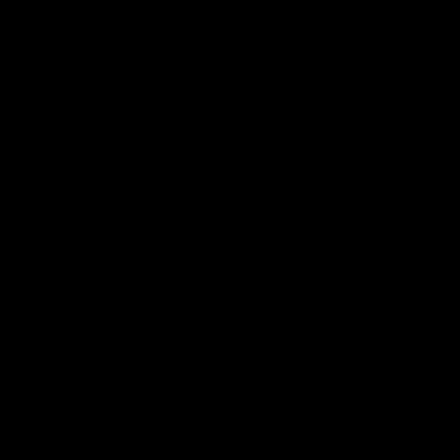

-1

In [27]:
from google.colab.patches import cv2_imshow
for i_, sample_batched in enumerate(dataloaders["train"]):
    img, Orig_images_batch, label_batch, path_batch = sample_batched['input_img'], sample_batched['orig_img'], sample_batched['label'], sample_batched['path']
    #print(img.shape)
    img=img.cuda()
    output=model(img)
    print(output.shape)
    #print(output)
    
    output=output.detach().cpu()
    img=img.cpu()
    output=output.numpy()
    final=[]
    print("end")
    print(output.shape[0])
    print("end")
    
    for i in range(output.shape[0]):
      for j in range(output.shape[1]):
        for k in range(output.shape[2]):
          final.append(output[i][j][k][:4])
          final.append(output[i][j][k][4:8])
    print(final)
    print(len(final))
    a=final
    print(img.shape)
    for i in range(len(a)):
      print(a[i][0])
      for l in range(len(a[0])):
        a[i][l]=a[i][l]*448
        print(a[i][l])
      xmin=max(int(a[i][0]-a[i][2]/2),0)
      xmax=max(int(a[i][0]+a[i][2]/2),0)
      ymin=max(int(a[i][1]-a[i][3]/2),0)
      ymax=max(int(a[i][1]+a[i][3]/2),0)
      print(type(xmin))
      start_point=(xmin,ymin)
      end_point=(xmax,ymax)
      color=(255,0,0)
      img=img.reshape(3,448,448)
      img=np.array(img)
      #img=img*255
      img=img.transpose(1,2,0)
      print(img)
      
      print(type(img),"   ",start_point,"    ",end_point)
      #cv2.rectangle(img,start_point,end_point,(200,0,0),3)
    break
cv2_imshow(img)
cv2.waitKey(0)
 

In [10]:
model=torch.load("/content/gdrive/MyDrive/yolov1.pt")